In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Link dataset
https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import pandas_profiling as pp
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
!mkdir dataset
!unzip "/content/drive/MyDrive/Dataset/predict-future-sales.zip" -d "/content/dataset"

mkdir: cannot create directory ‘dataset’: File exists
Archive:  /content/drive/MyDrive/Dataset/predict-future-sales.zip
replace /content/dataset/item_categories.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Read the data
data_train = pd.read_csv("/content/dataset/sales_train.csv")
data_test = pd.read_csv("/content/dataset/test.csv")
item_categories = pd.read_csv("/content/dataset/item_categories.csv")
item = pd.read_csv("/content/dataset/items.csv")
shops = pd.read_csv("/content/dataset/shops.csv")
sample_submission = pd.read_csv("/content/dataset/sample_submission.csv")

In [ ]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [ ]:
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
data_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
data_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
data_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


### Preprocessing

In [ ]:
# Remove the missing values
def missing_value(data):
    missing_data = pd.DataFrame({
        'Missing_count':data.isnull().sum(),
        'Missing_part':data.isnull().sum()/len(data)
    })
    missing_data = missing_data[missing_data['Missing_count']!=0]

    return missing_data

missing_value(data_train)

,Missing_count,Missing_part


In [ ]:
missing_value(data_test)

,Missing_count,Missing_part


In [ ]:
# Data duplicate
if (data_train.duplicated().sum() != 0 ):
    data_train.drop_duplicates(keep = 'first', inplace=True)
    print(data_train.duplicated().sum())

0


In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935843 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 156.8+ MB


In [ ]:
# change date type to datetime
data_train['date'] = pd.to_datetime(data_train['date'])
data_train['date'] = data_train['date'].apply(lambda x: x.strftime('%Y-%m'))
data_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02,0,59,22154,999.00,1.0
1,2013-03,0,25,2552,899.00,1.0
2,2013-05,0,25,2552,899.00,-1.0
3,2013-06,0,25,2554,1709.05,1.0
4,2013-01,0,25,2555,1099.00,1.0


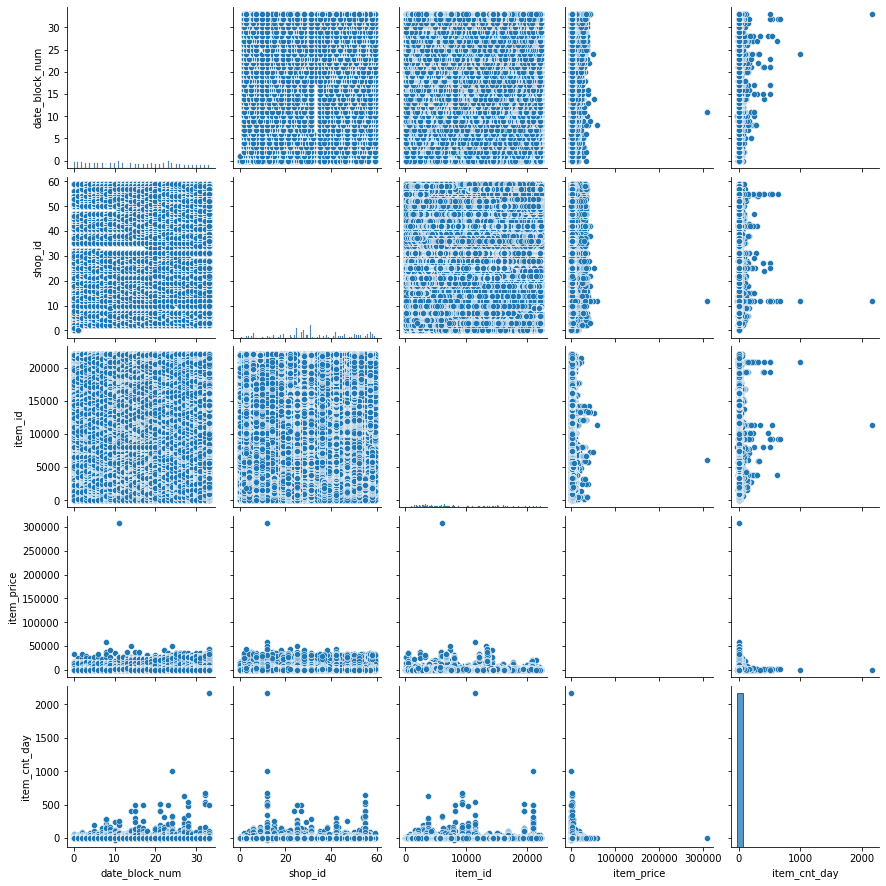

In [ ]:
sns.pairplot(data_train)

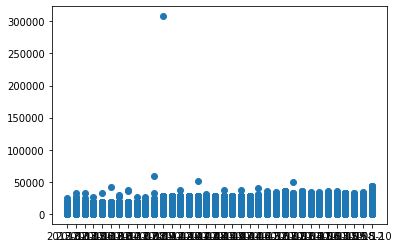

In [ ]:
plt.scatter(data_train['date'], data_train['item_price'])

In [ ]:
# Remove the outliers (item_price)
data_train[data_train.item_price > 100000]
data_train.drop(1163158,inplace = True)

In [ ]:
# Drop columns
data_train.drop(['date_block_num', 'item_price'], axis=1, inplace=True)
data_train.head()

,date,shop_id,item_id,item_cnt_day
0,2013-02,59,22154,1.0
1,2013-03,25,2552,1.0
2,2013-05,25,2552,-1.0
3,2013-06,25,2554,1.0
4,2013-01,25,2555,1.0


In [ ]:
# Data train
df_train = data_train.groupby(['date','shop_id','item_id']).sum()
df_train = df_train.pivot_table(index=['shop_id','item_id'], 
                                columns='date', 
                                values='item_cnt_day', 
                                fill_value=0)

df_train.reset_index(inplace=True)
df_train.head()

date,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12
0,0,30,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,31,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,32,4,6,2,0,1,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,33,2,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,35,2,6,0,1,0,2,0,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Data test
df_test = pd.merge(data_test, df_train, on=['shop_id','item_id'], how='left')
df_test.drop(['ID'], axis=1, inplace=True)
df_test = df_test.fillna(0)
df_test.head()

,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model

In [ ]:
X_train = df_train.drop(['2015-12'], axis = 1)
Y_train = df_train['2015-12'].values

x_test = df_test.drop(['2013-01'], axis=1)
print(X_train.shape, Y_train.shape)
print(x_test.shape)

(424123, 37) (424123,)
(214200, 37)


In [ ]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)
print(X_train.shape)
print(y_train.shape)

(424123, 37)
(339298,)


In [ ]:
# Linear Regression
LR = LinearRegression()
LR.fit(x_train, y_train)

print('Train set mse:', mean_squared_error(y_train, LR.predict(x_train)))
print('Val set mse:', mean_squared_error(y_val, LR.predict(x_val)))


Train set mse: 0.15741671868292337
Val set mse: 0.09130658344775258


In [ ]:
# Gradient boosting Regression
gbr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
gbr.fit(x_train, y_train)

print('Train set mse:', mean_squared_error(y_train, gbr.predict(x_train)))
print('Val set mse:', mean_squared_error(y_val, gbr.predict(x_val)))

Train set mse: 0.057374826537003945
Val set mse: 0.08582520039867746


In [ ]:
# Predict using gradient boosting regression
pred_test = gbr.predict(x_test)

### Submission

In [ ]:
submission = pd.DataFrame({
    'ID':data_test['ID'],
    'item_cnt_month':pred_test
})
submission.to_csv('submission.csv', index=False)

In [ ]:
submission.head()

,ID,item_cnt_month
0,0,0.275035
1,1,0.007330
2,2,0.295326
3,3,0.030613
4,4,0.007330
